In [1]:
import numpy as np
from astropy.io import fits
from astropy.time import Time
from astropy import units as u
import aplpy
import matplotlib.pyplot as plt
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

import dd.dynamics
from alma.image import rotate_zxz

%load_ext autoreload
%autoreload 2
%matplotlib notebook

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<IPython.core.display.Javascript object>


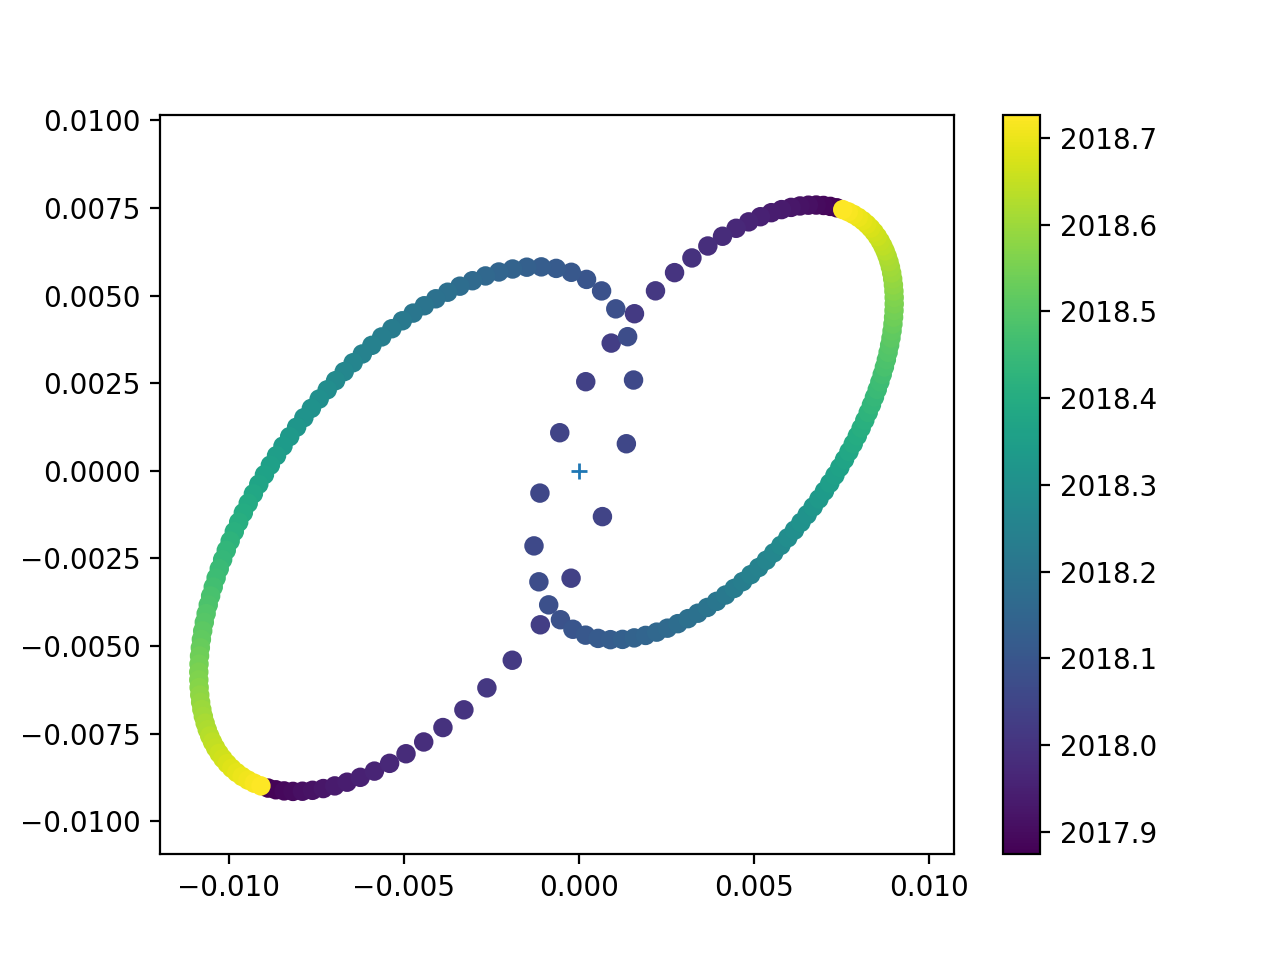

In [26]:
# binary orbits, a, e, i, w, Om, P (d), T, m2/m1
# Boden give pericenter for Ba, so add 180 for Bb

# AB orbit
ab = [1.0519, 0.43, 87.92, 69.7, 4.2, 205.57, 2024.16, 1.28/1.3]     # updated Tokovinin
ab = [1.00216601e+00, 4.68094062e-01, 8.83763954e+01, 7.89663846e+01,
 4.69230577e+00, 1.93363445e+02, 2.02586348e+03, 1.28/1.3]  # best fit including new RV

# Boden
babb = [0.023, 0.785, 66.8, 109.6+180, 337.6, 314.327, 2002.563, 0.58/0.7]
# babb = [0.023, 0.785, 13.5, 90., 61., 314.327, 2002.563, 0.58/0.7]

t0 = 2017.8740244975938 # babb[6]
t_babb = np.linspace(t0, t0+babb[5]/365.25, 100, endpoint=False)
x_ba, x_bb = dd.dynamics.binary_ephemeris(*babb[:5], t_babb, q=babb[7], t=babb[6], period=babb[5]/365.25)

fig, ax = plt.subplots()
ax.axis('equal')
ax.scatter(x_ba[0], x_ba[1], c=t_babb)#x_ba[2]/np.max(np.abs(x_ba[2])))
_ = ax.scatter(x_bb[0], x_bb[1], c=t_babb)#x_bb[2]/np.max(np.abs(x_bb[2])))
ax.plot(0,0,'+')
fig.colorbar(_)

t_aba = np.linspace(1825, 2017.8740244975938, 100, endpoint=True)
x_aba = dd.dynamics.sky_orbit(*ab[:5], t_aba, t=ab[6], period=ab[5], primary=True)
# ax.scatter(x_aba[0], x_aba[1])

In [4]:
data_dir = '../../../data/alma/'

image = data_dir+'hd98800-b6/hd98800.pcal1.cont.uniform.fits'
image_nat = data_dir+'hd98800-b6/hd98800.pcal1.cont.natural.fits'
image_nat_spw04 = data_dir+'hd98800-b6/hd98800.pcal1.cont.spw04.natural.fits'
resid = data_dir+'hd98800-b6/hd98800.pcal1.cont.natural.residual.fits'
mom0 = data_dir+'hd98800-b6/hd98800.pcal1.CO.natural.mom0.fits'
mom1 = data_dir+'hd98800-b6/hd98800.pcal1.CO.natural.mom1.0025.fits'
fit_pe_resid = 'power_2d_ecc_rin/residual.uniform.fits'
fit_pe_resid_nat = 'power_2d_ecc_rin/residual.natural.fits'
fit_p_resid = 'power_2d/residual.uniform.fits'
fit_p_resid_nat = 'power_2d/residual.natural.fits'

In [5]:
# make a mJy/beam image
for f in [image,image_nat,image_nat_spw04,mom0,fit_pe_resid,fit_pe_resid_nat,fit_p_resid,fit_p_resid_nat]:
    h = fits.open(f)[0]
    im = fits.getdata(f) * 1e3
    h.header['BUNIT'] = 'mJy/beam'
    f_out = f + '_mJyperbeam'
    fits.writeto(f_out,im,header=h.header,overwrite=True)
    
image = image+'_mJyperbeam'
image_nat = image_nat+'_mJyperbeam'
image_nat_spw04 = image_nat_spw04+'_mJyperbeam'
resid = resid+'_mJyperbeam'
mom0 = mom0+'_mJyperbeam'
fit_pe_resid = fit_pe_resid+'_mJyperbeam'
fit_pe_resid_nat = fit_pe_resid_nat+'_mJyperbeam'
fit_p_resid = fit_p_resid+'_mJyperbeam'
fit_p_resid_nat = fit_p_resid_nat+'_mJyperbeam'

In [60]:
def make_fig(image_file, contour_file=None, noise_image=None, vmax=None, vmin=None,
             bar_label='Flux density / mJy beam$^{-1}$',
             contours=[-4,-3,-2,2,3,4,5,6,7], contour_colours='black',
             contour_file_2=None, contours_2=[20], contour_colours_2='lightgrey', linestyles2=None,
             orbit_colours='white',
             show_ab_orbit=False, show_b_orbit=True, show_b_loc=True, show_a_loc=False, show_b_label=False,
             ra_off=-6.39108910e-02, dec_off=6.18456378e-01,
             fig_size=0.4, figsize=None, cmap='magma', colourbar=True, beam=True, font_size='x-large',
             hide_x=False, hide_y=False, hide_tick_labels=False,
             scalebar=False, scalebar_length=1, scalebar_colour='white', scalebar_label='1 au',
             write_dir='../../../doc/hd98800/figs/',file_name='image.pdf'):

    ra_off /= 3600
    dec_off /= 3600
    
    rgb_orb = matplotlib.colors.to_rgb(orbit_colours)

    fig = aplpy.FITSFigure(image_file, figsize=figsize)
    fig.show_colorscale(stretch='linear',vmin=vmin,vmid=None,vmax=vmax,
                        cmap=plt.cm.get_cmap(cmap))

    fig.set_nan_color('white')

    if contour_file is not None:
        if noise_image is None:
            noise_image = fits.getdata(contour_file).squeeze()
        std_res = np.std(noise_image)
        print('std for contour:{}'.format(std_res))
        fig.show_contour(data=contour_file, levels=np.array(contours)*std_res, colors=contour_colours, linewidth=2)

    if contour_file_2 is not None:
        std_res = np.std(fits.getdata(contour_file_2).squeeze())
        fig.show_contour(data=contour_file_2, levels=np.array(contours_2)*std_res,
                         colors=contour_colours_2, linestyles=linestyles2, linewidth=2)

    fig.ticks.set_color('black')
    fig.ticks.set_length(3)
#     fig.ticks.set_minor_frequency(100)
    fig.tick_labels.set_xformat('dd:mm:ss.s')
    fig.tick_labels.set_yformat('dd:mm:ss.s')
    fig.tick_labels.set_font(size=font_size)
    fig.axis_labels.set_font(size=font_size)
    if hide_x:
        fig.tick_labels.hide_x()
        fig.axis_labels.hide_x()
    if hide_y:
        fig.tick_labels.hide_y()
        fig.axis_labels.hide_y()
    if hide_tick_labels:
        fig.tick_labels.hide_x()
        fig.tick_labels.hide_y()       
        
    if scalebar:
        fig.add_scalebar(scalebar_length/44.9 * u.arcsecond)
        fig.scalebar.set_length(scalebar_length/44.9 * u.arcsecond)
        fig.scalebar.set_corner('top right')
        fig.scalebar.set_color(scalebar_colour)
        fig.scalebar.set_font(size=font_size)
        fig.scalebar.set(linewidth=3)
        fig.scalebar.set_label(scalebar_label)

    if colourbar:
        fig.add_colorbar()
        fig.colorbar.set_axis_label_text(bar_label)
        fig.colorbar.set_axis_label_font(size=font_size)
        fig.colorbar.set_label_properties(size=font_size)

    h = fits.getheader(image_file)

    # orbits
    x0 = h['CRVAL1'] + ra_off
    y0 = h['CRVAL2'] + dec_off
    print(x0,y0)
    if show_b_orbit:
        c = [rgb_orb+(a,) for a in np.linspace(0,1,len(t_babb))]
        points = np.array([x0-x_ba[0]/3600., y0+x_ba[1]/3600.]).T.reshape(-1, 1, 2)
        segments = np.rollaxis(np.concatenate([points[:-1], points[1:]], axis=1), 2, 1)
        fig.show_lines(segments, color=c, linewidth=2)
        points = np.array([x0-x_bb[0]/3600., y0+x_bb[1]/3600.]).T.reshape(-1, 1, 2)
        segments = np.rollaxis(np.concatenate([points[:-1], points[1:]], axis=1), 2, 1)
        fig.show_lines(segments, color=c, linewidth=2)
#         fig.show_lines( [np.vstack((x0-x_ba[0]/3600., y0+x_ba[1]/3600.))],   color=orbit_colours )
#         fig.show_lines( [np.vstack((x0-x_bb[0]/3600., y0+x_bb[1]/3600.))],   color=orbit_colours )

    if show_ab_orbit:
        c = [rgb_orb+(a,) for a in np.linspace(0,1,len(t_aba))]
        points = np.array([x0-x_aba[0]/3600., y0+x_aba[1]/3600.]).T.reshape(-1, 1, 2)
        segments = np.rollaxis(np.concatenate([points[:-1], points[1:]], axis=1), 2, 1)
        fig.show_lines(segments, color=c, linewidth=2)
#         fig.show_lines( [np.vstack((x0-x_aba[0]/3600., y0+x_aba[1]/3600.))], color=orbit_colours )

    # position of AaAb at obs, toggle label for zoom
    t = Time(h['DATE-OBS'])
    print(t.byear)
    if show_a_loc:
        x_obs, y_obs, _ = dd.dynamics.sky_orbit(*ab[:5], np.array([t.byear]), t=ab[6], period=ab[5], primary=True)
        fig.show_markers( x0-x_obs/3600., y0+y_obs/3600., edgecolor='w', facecolor=orbit_colours, alpha=0.7 )
        fig.add_label(x0-(x_obs[0]+0.2)/3600., y0+y_obs[0]/3600., 'AaAb', color='w', size=font_size)
    if show_b_loc:
        x_ba1, x_bb1 = dd.dynamics.binary_ephemeris(*babb[:5], np.array([t.byear]), q=babb[7],
                                                    t=np.array([babb[6]]), period=babb[5]/365.25)
        fig.show_markers( x0-x_ba1[0]/3600., y0+x_ba1[1]/3600., edgecolor='w', facecolor=orbit_colours, alpha=0.7 )
        fig.show_markers( x0-x_bb1[0]/3600., y0+x_bb1[1]/3600., edgecolor='w', facecolor=orbit_colours, alpha=0.7 )
    if show_b_label:
        fig.add_label( x0-(x_ba1[0][0]-0.0)/3600., y0+(x_ba1[1][0]+0.01)/3600., 'Ba', color='w', size=font_size)
        fig.add_label( x0-(x_bb1[0][0]+0.0)/3600., y0+(x_bb1[1][0]-0.012)/3600., 'Bb', color='w', size=font_size)

    # point opposite AaAb
#     dyr = (t.byear-ab[6]) % ab[5]                   # time since last pericenter passage
#     m = dyr / ab[5] * np.pi*2                       # mean anomaly (radians)
#     m = np.array([m]) + np.pi                       # opposite side of orbit
#     f = np.rad2deg( dd.dynamics.convmf(m, ab[1]) )  # true anomaly (degrees)
#     print(f)
#     x_obs, y_obs, _ = dd.dynamics.sky_orbit(*ab[:5], np.array([t.byear]), anomaly=f, primary=True)
#     fig.show_markers( x0-x_obs/3600., y0+y_obs/3600., edgecolor='w', facecolor=orbit_colours, alpha=0.7 )

    if beam:
        fig.add_beam()
        print('beam:{}x{}'.format(h['BMAJ']*3600,h['BMIN']*3600))
        fig.beam.set_major(h['BMAJ'])  # degrees
        fig.beam.set_minor(h['BMIN'])  # degrees
        fig.beam.set_angle(h['BPA'])  # degrees
        fig.beam.set_edgecolor('white')
        fig.beam.set_facecolor('grey')

    try:
        fig.recenter(x0, y0, width=fig_size[0]/3600., height=fig_size[1]/3600.)
    except:
        fig.recenter(x0, y0, width=fig_size/3600., height=fig_size/3600.)
        
    fig.save(write_dir+file_name, dpi=100)

INFO: Setting slices=[0, 0] [aplpy.core]


<IPython.core.display.Javascript object>


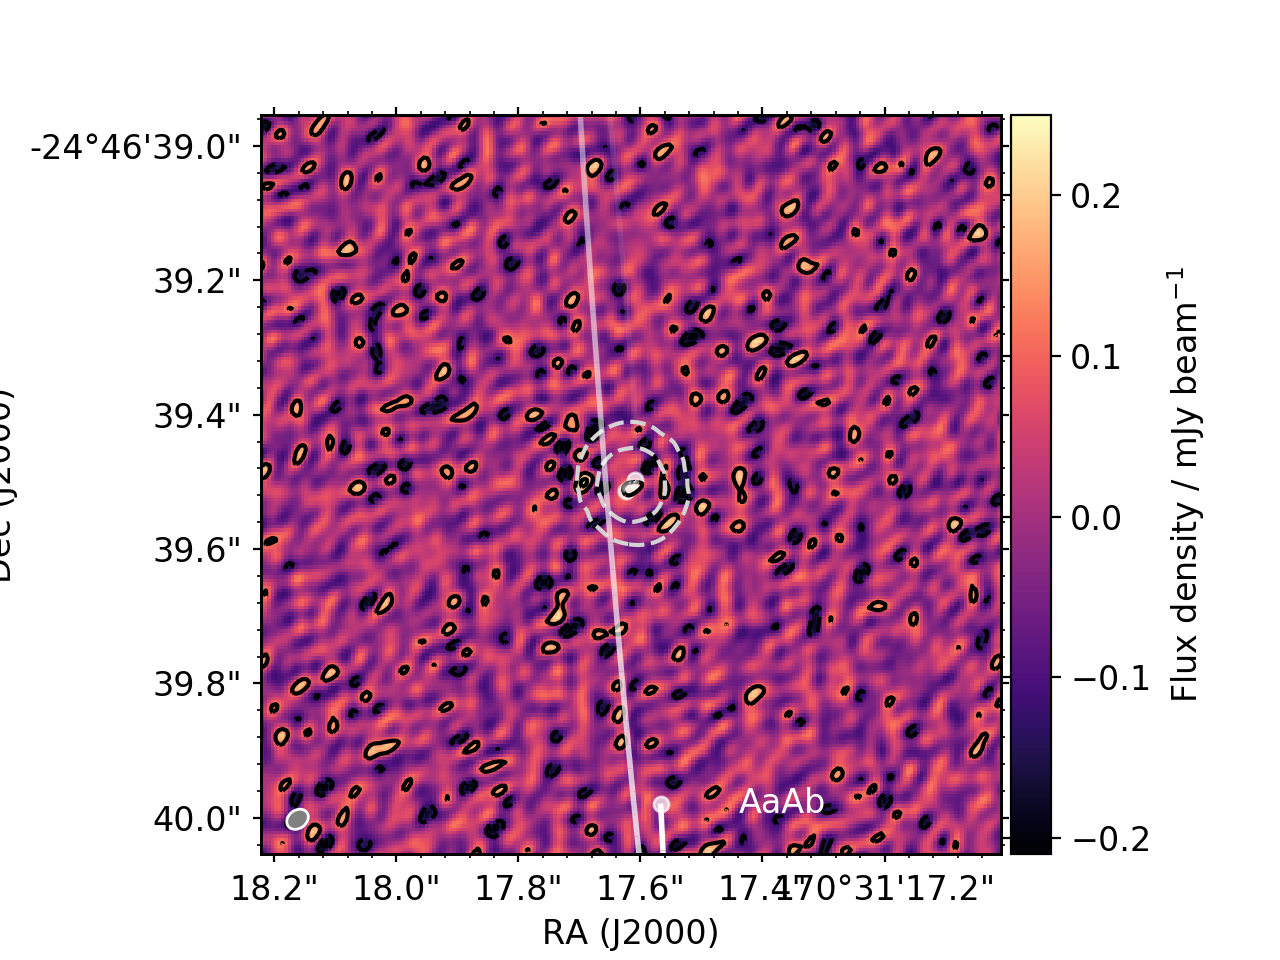

INFO: Auto-setting vmin to -2.103e-01 [aplpy.core]
std for contour:0.06018701195716858
INFO: Setting slices=[0, 0] [aplpy.core]


/usr/local/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


INFO: Setting slices=[0, 0] [aplpy.core]


170.52155986137473 -24.777640090611666
2017.8740245614786
beam:0.034645318984983596x0.027004292234776798


In [75]:
# make_fig(image, vmax=2., show_ab_orbit=False, file_name='image_zoom.pdf', hide_y=True,
#          scalebar=True, show_b_label=True, font_size='large')
# make_fig(image, vmax=2., show_ab_orbit=True, file_name='image.pdf', font_size='large',
#          colourbar=False, scalebar=True, scalebar_length=5, scalebar_label='5 au',
#          fig_size=[1.2,2.4], show_a_loc=True, show_b_loc=False, hide_x=True)

# make_fig(image_nat_spw04, show_ab_orbit=False, file_name='image_spw04_zoom_contour.pdf', scalebar=True, vmax=6.5,
#          noise_image=fits.getdata(fit_pe_resid_nat).squeeze(),
#          contour_file=image_nat, contour_colours='white', contours=[100,250,280])

# make_fig(mom0, vmax=32, show_ab_orbit=False, file_name='mom0-zoom.pdf', contour_file=mom0,
#          noise_image=fits.getdata(mom0).squeeze(), contour_file_2=image_nat, contours_2=[20],
#          figsize=(5,5), font_size='large')

# make_fig(mom1, show_ab_orbit=False, file_name='mom1-zoom.pdf', contour_file=image_nat, contours=[20],
#          fig_size=0.35, orbit_colours='black', bar_label='Velocity / km s$^{-1}$', cmap='rainbow',
#          vmax=5.1+9, vmin=5.1-9, figsize=(5,5), hide_tick_labels=True,
#          scalebar=True, scalebar_length=1, scalebar_colour='black', scalebar_label='1 au')

# make_fig(resid, vmax=0.06, show_ab_orbit=True, file_name='clean-resid.pdf', scalebar=True, scalebar_length=5,
#          fig_size=2.4, show_a_loc=True, show_b_loc=False, beam=False)

make_fig(fit_pe_resid, show_ab_orbit=True, file_name='resid_zoom.pdf', contour_file=fit_pe_resid, vmax=0.25,
         contours=[-4,-2,2,4], contour_colours='black',#('w','w','w','black','black','black'),
        contour_file_2=image, linestyles2='--', fig_size=1.1, orbit_colours='w',
        show_a_loc=True, font_size='large')
# make_fig(fit_pe_resid_nat, show_ab_orbit=True, file_name='resid_nat_zoom.pdf', contour_file=fit_pe_resid_nat,
#          vmax=0.15, contours=[-4,-2,2,4], contour_colours='black',#('w','w','black','black'),
#         contour_file_2=image_nat, linestyles2='--', fig_size=1.1, orbit_colours='w',
#         show_a_loc=True, font_size='large')

# make_fig(fit_p_resid_nat, show_ab_orbit=True, file_name='resid_power_nat_zoom.pdf', contour_file=fit_p_resid_nat,
#          vmax=0.25, contours=[-4,-2,2,4,6], contour_colours='black',#('w','w','black','black'),
#          contour_file_2=image_nat, linestyles2='--', fig_size=1.1, orbit_colours='w',
#          show_a_loc=True)

In [32]:
# think about orientation and angles
babb_l = np.matmul(rotate_zxz(0, 66.8+90, 337.6+90), [0,1,0])
babb_peri = np.matmul(rotate_zxz(109.6+180, 66.8, 337.6+90), [1,0,0])
disk1_l = np.matmul(rotate_zxz(0, 26+90, 16+90), [0,1,0])
disk2_l = np.matmul(rotate_zxz(0, 154+90, 16+90), [0,1,0])

print(babb_l, babb_peri, disk2_l)
print('babb vs. disk L: {}'.format(np.rad2deg(np.arccos(np.dot(babb_l,disk1_l)))))
print('babb vs. disk L: {}'.format(np.rad2deg(np.arccos(np.dot(babb_l,disk2_l)))))
print('babb peri vs. disk L: {}'.format(np.rad2deg(np.arccos(np.dot(babb_peri,disk2_l)))))

[ 0.84978293 -0.35025525  0.39394191] [ 0.4709444   0.16871914 -0.8658783 ] [ 0.42138939  0.12083146 -0.89879405]
babb vs. disk L: 47.94525959990534
babb vs. disk L: 92.1952509944568
babb peri vs. disk L: 4.376741943183951


In [4]:
t0 = babb[6]
t = np.linspace(t0, t0+babb[5]/365.25, 500, endpoint=False)
x_ba, x_bb = dd.dynamics.binary_ephemeris(*babb[:5], t, q=babb[7], t=babb[6], period=babb[5]/365.25)

_, x_disk = dd.dynamics.binary_ephemeris(0.073, 0, 154, 0, 16, t, q=1e-6, anomaly=np.linspace(0,360) )

<IPython.core.display.Javascript object>


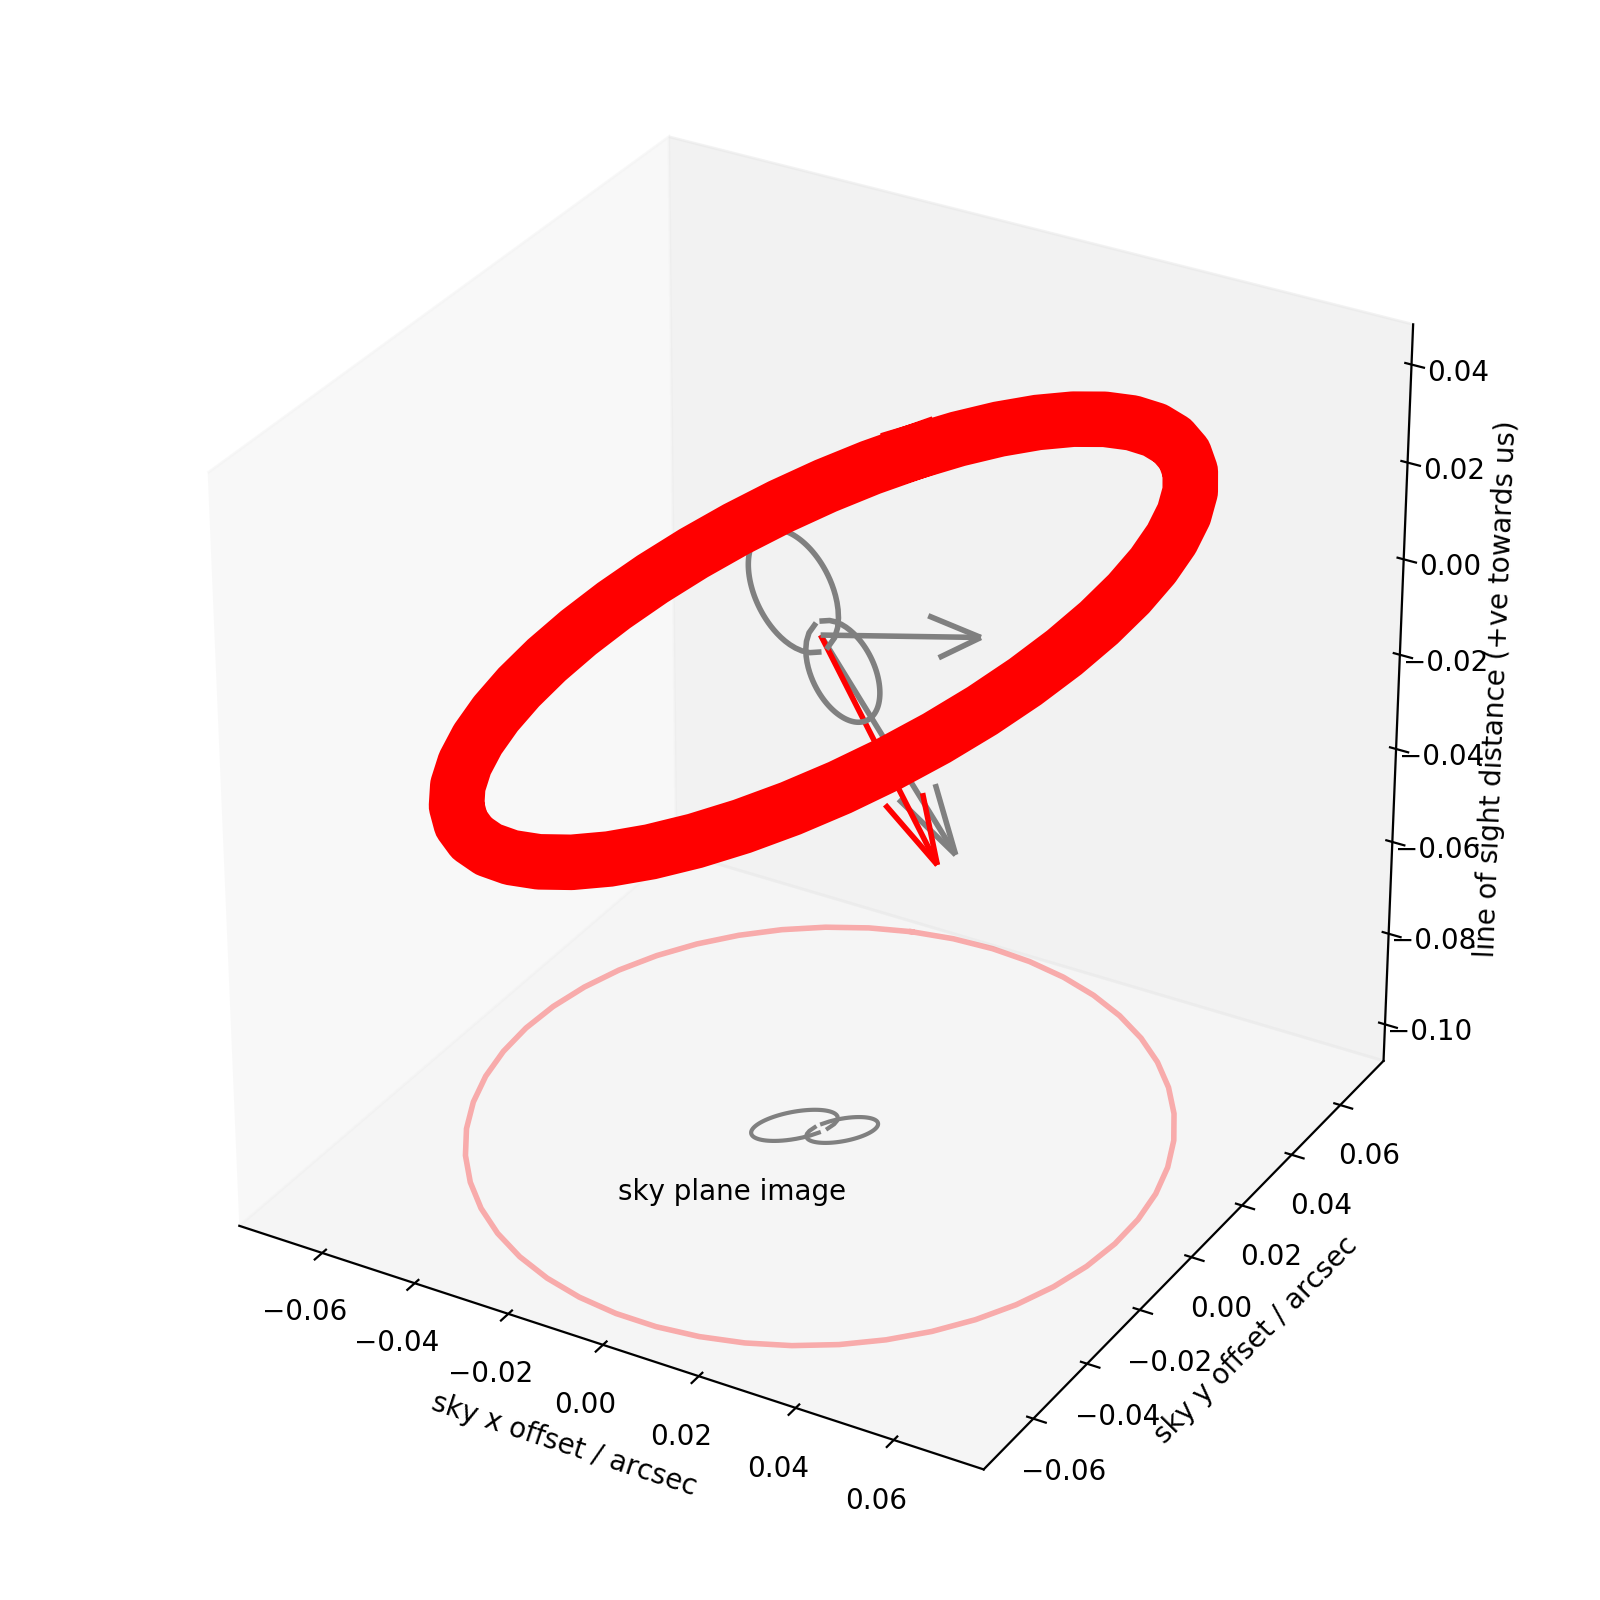

In [7]:
sz = 0.075
zoff = 0.03
r = 0.02
l = 2.5
lw = 2

fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
ax.quiver(0,0,0,*babb_l*r, color='grey', length=l, linewidth=lw, arrow_length_ratio=0.3)
ax.quiver(0,0,0,*babb_peri*r, color='grey', length=l, linewidth=lw, arrow_length_ratio=0.3)
ax.plot(*x_ba, color='grey', linewidth=lw)
ax.plot(*x_bb, color='grey', linewidth=lw)
ax.plot(*x_disk, color='red', linewidth=20, alpha=1)
ax.quiver(0,0,0,*disk2_l*r, color='red', length=l, linewidth=lw, arrow_length_ratio=0.3)

ax.plot(x_ba[0], x_ba[1], -sz-zoff, color='grey', zdir='z')
ax.plot(x_bb[0], x_bb[1], -sz-zoff, color='grey', zdir='z')
ax.plot(x_disk[0], x_disk[1], -sz-zoff, color='red', linewidth=2, alpha=0.3)
ax.text(-0.02,-0.04,-sz-zoff, 'sky plane image', )

ax.set_xlim(-sz,sz)
ax.set_ylim(-sz,sz)
ax.set_zlim(-sz-zoff,sz-zoff)
ax.set_xlabel('sky x offset / arcsec')
ax.set_ylabel('sky y offset / arcsec')
ax.set_zlabel('line of sight distance (+ve towards us)')

ax.grid(False)

fig.tight_layout()
fig.savefig('../../../doc/hd98800/figs/3d.pdf')

In [24]:
# try a 3d cartoon

import plotly.plotly as py
import plotly.offline as po
import plotly.figure_factory as FF
import plotly.graph_objs as go

from scipy.spatial import Delaunay

po.init_notebook_mode()

r = 3.5
dr = 0.5
sz = 4.8
pa = 16.
inc = 26.

u = np.linspace(0, 2*np.pi, 50)
v = np.linspace(0, 2*np.pi, 50)
u,v = np.meshgrid(u,v)
u = u.flatten()
v = v.flatten()
x = (r + dr*(np.cos(v)))*np.cos(u)
y = (r + dr*(np.cos(v)))*np.sin(u)
z = np.sin(v)*dr
x, y, z = np.matmul(rotate_zxz(0, 180-inc, pa+90), [x, y, z])

points2D = np.vstack([u,v]).T
tri = Delaunay(points2D)
simplices = tri.simplices
disk = FF.create_trisurf(x=x, y=y, z=z, simplices=simplices, show_colorbar=False)['data'][0]
disk['facecolor'] = np.repeat('rgb(140, 100, 50)', len(disk['i']))

orb_a = go.Scatter3d(x=x_ba[0]*44.9, y=x_ba[1]*44.9, z=x_ba[2]*44.9,
                     line=dict(width=6, color='rgb(100,100,100)'), opacity=0.7, marker=dict(size=1, showscale=False))
orb_b = go.Scatter3d(x=x_bb[0]*44.9, y=x_bb[1]*44.9, z=x_bb[2]*44.9,
                     line=dict(width=6, color='rgb(150,150,150)'), opacity=0.7, marker=dict(size=1, showscale=False))

babb_peri = np.matmul(rotate_zxz(109.6+180, 66.8, 337.6+90), [1,0,0])
peri = go.Scatter3d(x=[-babb_peri[0]*r,babb_peri[0]*r],
                    y=[-babb_peri[1]*r,babb_peri[1]*r],
                    z=[-babb_peri[2]*r,babb_peri[2]*r],
                    mode='lines', line={'width':4, 'color':'rgb(150,150,150)'})

disk2_l = np.matmul(rotate_zxz(0, 154+90, 16+90), [0,1,0])
diskl = go.Scatter3d(x=[-disk2_l[0]*r,disk2_l[0]*r],
                     y=[-disk2_l[1]*r,disk2_l[1]*r],
                     z=[-disk2_l[2]*r,disk2_l[2]*r],
                     mode='lines', line={'width':4, 'dash':'dash', 'color':'rgb(155, 100, 50)'})

# planes
pa_xyz1 = [0,-(r+dr)*1.2,0]
pa_xyz2 = np.matmul(rotate_zxz(0, 0, pa), pa_xyz1)
pa_xyz3 = np.matmul(rotate_zxz(pa+90, inc, pa-90), pa_xyz1)

pa1 = go.Scatter3d(x=[0,pa_xyz1[0]], y=[0,pa_xyz1[1]], z=[0,pa_xyz1[2]],
                  mode='lines', line={'width':4, 'color':'black'}, opacity=0.8)
pa2 = go.Scatter3d(x=[0,pa_xyz2[0]], y=[0,pa_xyz2[1]], z=[0,pa_xyz2[2]],
                  mode='lines', line={'width':4, 'color':'black'}, opacity=0.8)
pa3 = go.Scatter3d(x=[0,pa_xyz3[0]], y=[0,pa_xyz3[1]], z=[0,pa_xyz3[2]],
                  mode='lines', line={'width':4, 'color':'black'}, opacity=0.8)

pa1 = go.Mesh3d(x=[pa_xyz1[0],pa_xyz2[0],0],
                y=[pa_xyz1[1],pa_xyz2[1],0],
                z=[pa_xyz1[2],pa_xyz2[2],0],
                opacity=0.7, color='grey')
pa2 = go.Mesh3d(x=[pa_xyz2[0],pa_xyz3[0],0],
                y=[pa_xyz2[1],pa_xyz3[1],0],
                z=[pa_xyz2[2],pa_xyz3[2],0],
                opacity=0.7, color='darkred')

# coordinate arrows
cen = [-3,-2,1]
axx = go.Scatter3d(x=np.array([0,-1])+cen[0], y=np.array([0,0])+cen[1], z=np.array([0,0])+cen[2],
                   mode='lines', line={'width':4, 'color':'black'}, opacity=1)
axy = go.Scatter3d(x=np.array([0,0])+cen[0], y=np.array([0,1])+cen[1], z=np.array([0,0])+cen[2],
                   mode='lines', line={'width':4, 'color':'black'}, opacity=1)
axz = go.Scatter3d(x=np.array([0,0])+cen[0], y=np.array([0,0])+cen[1], z=np.array([0,1])+cen[2],
                   mode='lines', line={'width':4, 'color':'black'}, opacity=1)

data = [disk, orb_a, orb_b, peri, diskl, pa1, pa2, axx, axy, axz]#, pa3]

layout = go.Layout(
    showlegend=False,
    scene = dict(
        aspectratio={'x':1, 'y':1, 'z':0.75},
        camera = dict(
    #         up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=0.5, y=-0.9, z=0.55)
            ),
        aspectmode = "manual",
        xaxis=dict(range=[-sz, sz],
#                    title='x / au', titlefont={'size':12}, tickfont={'size':10},
                   showgrid=False, showticklabels=False, zeroline=False, ticks='', title=''
                   ),
        yaxis=dict(range=[-sz, sz],
#                    title='y / au', titlefont={'size':12}, tickfont={'size':10},
                   showgrid=False, showticklabels=False, zeroline=False, ticks='', title=''
                   ),
        zaxis=dict(range=[-sz*0.75, sz*0.75],
#                    title='z / au', titlefont={'size':12}, tickfont={'size':10},
                   showgrid=False, showticklabels=False, zeroline=False, ticks='', title=''
                   ),
    )
)
    
fig = dict(data=data, layout=layout)

po.iplot(fig, image_width=1200, image_height=1200, validate=False, image='png', filename='3d')

In [61]:
# peri = {'type':'cone',
#         'x':[babb_peri[0]*0.8*r], 'y':[babb_peri[1]*0.8*r], 'z':[babb_peri[2]*0.8*r],
#         'u':[babb_peri[0]*r], 'v':[babb_peri[1]*r], 'w':[babb_peri[2]*r],
#         'sizemode':'absolute', 'sizeref':0.1, 'showscale':False}
# diskl = {'type':'cone',
#         'x':[disk2_l[0]*0.8*r], 'y':[disk2_l[1]*0.8*r], 'z':[disk2_l[2]*0.8*r],
#         'u':[disk2_l[0]*r], 'v':[disk2_l[1]*r], 'w':[disk2_l[2]*r],
#         'sizemode':'absolute', 'sizeref':0.1, 'showscale':False}